# Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder, MinMaxScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

from datetime import datetime as dt
from sklearn.calibration import CalibratedClassifierCV
from scipy.stats import *
from imblearn.pipeline import make_pipeline
from imblearn.combine import SMOTEENN
from imblearn.over_sampling import SMOTE

import re

# Dataset

## Read

In [2]:
df = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Check Label

The following shows that the general probability of survival is 38%.

In [8]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

## Fare Category

We will try to split fare into 2 groups: Low fare and High fare. The idea is that a passenger with premium fare will be prioritized to the rescue boats. Thus, low fare means lower chance of survival. 

To find the threshold, we try multiple values (from 8 to 30). Calculate the survival percentage for passenger with fare lower than the threshold. We pick one value which minimizes the survival rate. 

The reason why we only test 8 - 30? To ensure that we have at least 100 passengers in each fare group, since there are only few passengers who paid less than 7. 

In [28]:
# Initial value
lowest_surv_prob = 1
threshold = 0
n_split = []

for i in range(8, 31):
    surv_prob = df[df['Fare'] < i]['Survived'].value_counts(normalize = True)[1]
    low_fare = df[df['Fare'] < i]['Fare'].count()
    high_fare = df[df['Fare'] >= i]['Fare'].count()

    if surv_prob < lowest_surv_prob:
        lowest_surv_prob = surv_prob
        threshold = i
        n_split = [low_fare, high_fare]

print('Lowest Survival Prob.', lowest_surv_prob)
print('Fare Threshold', threshold)
print('Group Size', n_split)

Lowest Survival Prob. 0.19935691318327975
Fare Threshold 9
Group Size [311, 580]


Observe that any passenger with fare < 8 only has 20% chance of surviving. This is noticably lower than the general probability, which is 38%. Thus, it makes sense for us to use this.

We propose a new idea. What if we further split the High fare? Let's say, 'Medium fare' and 'High fare'.

In [ ]:
# Initial value
lowest_surv_prob = 1
threshold = 0
n_split = []

for i in range(8, 31):
    surv_prob = df[df['Fare'] < i]['Survived'].value_counts(normalize = True)[1]
    low_fare = df[df['Fare'] < i]['Fare'].count()
    high_fare = df[df['Fare'] >= i]['Fare'].count()

    if surv_prob < lowest_surv_prob:
        lowest_surv_prob = surv_prob
        threshold = i
        n_split = [low_fare, high_fare]

print('Lowest Survival Prob.', lowest_surv_prob)
print('Fare Threshold', threshold)
print('Group Size', n_split)

## Total Family

In [163]:
df['TotalFamily'] = df['SibSp'] + df['Parch']
df_test['TotalFamily'] = df_test['SibSp'] + df_test['Parch']

## Get Title

The world is a cruel place. Well-recognized person is respected more. If age is less than 18, set title to Child.

In [164]:
def get_title(dfa):
    title = []
    recognized_title = ['Mr.', 'Mrs.', 'Miss.', 'Dr.', 'Major', 'Master', 'Rev', 'Ms.', 'Col.', 'Sir.', 'Capt.', 'Countess']

    for idx, name in enumerate(dfa['Name']):
        if dfa.loc[idx, 'Age'] < 16:
            title.append('Children')
            continue
        st = 0
        for tl in recognized_title:
            if tl in name:
                title.append(tl)
                st = 1
                break
        if not st:
            title.append('None')
    dfa['Title'] = title

    threshold = 5 # Anything that occurs less than this will be removed.
    value_counts = dfa['Title'].value_counts() 
    to_remove = value_counts[value_counts <= threshold].index
    dfa['Title'].replace(to_remove, 'Recognized', inplace=True)
    return (dfa)

df = get_title(df)
df_test = get_title(df_test)

## Cabin

In [165]:
# Fill missing value with a constant
df['Cabin'] = df['Cabin'].fillna('None')
df_test['Cabin'] = df_test['Cabin'].fillna('None')

# Get first letter
df['Cabin'] = [i[0] for i in df['Cabin']]
df_test['Cabin'] = [i[0] for i in df_test['Cabin']]

## Drop Col

In [166]:
col_to_drop = ['PassengerId', 'Name', 'Ticket']

df = df.drop(col_to_drop, axis = 1)
df_test_id = df_test['PassengerId']
df_test = df_test.drop(col_to_drop, axis = 1)
df.head(2)

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,TotalFamily,Title
0,0,3,male,22.0,1,0,7.2500,N,S,1,Mr.
1,1,1,female,38.0,1,0,71.2833,C,C,1,Mrs.


## Ordinal Encoder

In [167]:
col_to_ohe = ['Sex', 'Cabin', 'Embarked', 'Title']

ohe = OneHotEncoder(sparse_output=False)
ohe.set_output(transform = 'pandas')

df_ohe = ohe.fit_transform(df[col_to_ohe])
df_test_ohe = ohe.transform(df_test[col_to_ohe])

df.drop(col_to_ohe, axis = 1, inplace = True)
df_test.drop(col_to_ohe, axis = 1, inplace = True)

df = pd.concat([df, df_ohe], axis = 1)
df_test = pd.concat([df_test, df_test_ohe], axis = 1)

## Check Label

<Axes: xlabel='Survived', ylabel='count'>

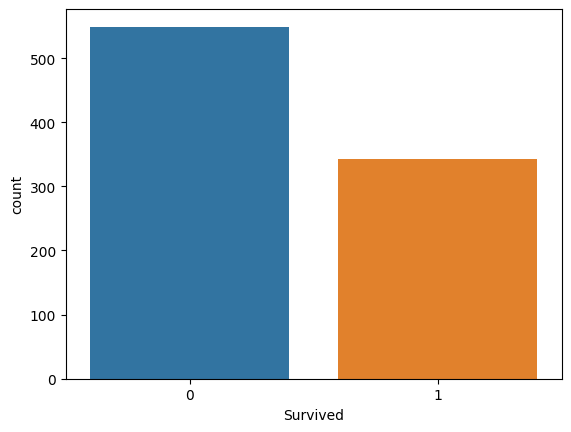

In [168]:
sns.countplot(df, x = 'Survived')

## Split X, y

In [169]:
y_train = df['Survived']
X_train = df.drop('Survived', axis = 1)
X_test = df_test

## Imputer for NaN

In [170]:
imputer = IterativeImputer(random_state=1333, initial_strategy='constant', min_value = 0, verbose = 1, max_iter = 50)
imputer.set_output(transform = 'pandas')

X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

any(X_train.isna().sum() > 0)

[IterativeImputer] Completing matrix with shape (891, 29)
[IterativeImputer] Change: 45.1362618568437, scaled tolerance: 0.5123292 
[IterativeImputer] Change: 0.0, scaled tolerance: 0.5123292 
[IterativeImputer] Early stopping criterion reached.
[IterativeImputer] Completing matrix with shape (418, 29)


False

## Scaling

In [180]:
stdsc = MinMaxScaler()
stdsc.set_output(transform = 'pandas')

X_train = stdsc.fit_transform(X_train)
X_test = stdsc.transform(X_test)

# Tune

In [181]:
def tune(estimator, param_distribution, X, y, X_test, idcol, modelname = 'Model', cv = StratifiedKFold(4, shuffle = True), n_iter = 50):
    cdt = dt.today().strftime('%Y-%m-%d')
    rs = RandomizedSearchCV(
        estimator=estimator,
        param_distributions=param_distribution,
        n_iter=n_iter,
        scoring='accuracy',
        cv=cv,
        verbose=1,
        random_state=423323,
        n_jobs=-1,
    )

    #CV results
    rs.fit(X, y)
    filename = '_'+modelname+'-'+str(cdt)+'-result.csv'
    pd.DataFrame(rs.cv_results_).to_csv(filename, index = False)
    print(rs.best_estimator_)

    model = rs.best_estimator_
    
    #Uncalibrated
    ypred = rs.predict(X_test)
    submission = pd.DataFrame({
        'PassengerId' : idcol,
        'Survived' : ypred
    }) 
    filename = '_'+modelname+'-'+str(cdt)+'-submission.csv'
    submission.to_csv(filename, index = False)

    #Calibrated
    cal = CalibratedClassifierCV(model)
    cal.fit(X, y)

    ypred = cal.predict(X_test)
    submission = pd.DataFrame({
        'PassengerId' : idcol,
        'Survived' : ypred
    })
    filename = '_'+modelname+'-calibrated-'+str(cdt)+'-submission.csv'
    submission.to_csv(filename, index = False)

    return(pd.DataFrame(rs.cv_results_))

In [182]:
# define the parameter distributions to search over
param_distribution1 = {
    'randomforestclassifier__n_estimators': randint(50, 500),  # Random integer between 100 and 500
    'randomforestclassifier__max_depth': [None, 5, 10, 15, 20, 25],  # Predefined values
    'randomforestclassifier__min_samples_split': randint(2, 18),  # Random integer between 2 and 20
    'randomforestclassifier__min_samples_leaf': randint(1, 9),  # Random integer between 1 and 10
    'randomforestclassifier__max_features': ['sqrt', 12, 16, 20],  # Predefined values
}

# create an instance of the LGBMClassifier estimator
estimator_1 = make_pipeline(
    RandomForestClassifier(bootstrap=True, oob_score=True)
)

res_lgbm1_ada = tune(estimator_1, param_distribution1, X_train, y_train, X_test, df_test_id, modelname = 'rf_2', n_iter = 2000)

Fitting 4 folds for each of 2000 candidates, totalling 8000 fits
Pipeline(steps=[('randomforestclassifier',
                 RandomForestClassifier(max_depth=20, min_samples_split=13,
                                        n_estimators=146, oob_score=True))])
